In [1]:
import numpy as np
from STMiner.SPFinder import SPFinder

sp = SPFinder()
sp.read_h5ad(file='I://Adult.h5ad', bin_size=50)

E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\conda\envs\dev\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not s

In [56]:
sp.flush_app()
sp.app.run()

In [2]:
sp.fit_pattern(n_top_genes=1000, n_comp=20, min_cells=200)

Fitting GMM...: 100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]


In [6]:
sp.build_distance_array()

Building distance array...: 100%|██████████| 1000/1000 [20:19<00:00,  1.22s/it]


In [7]:
sp.cluster_gene(n_clusters=7, mds_components=20, n_top_genes=800, use_highly_variable_gene=True)

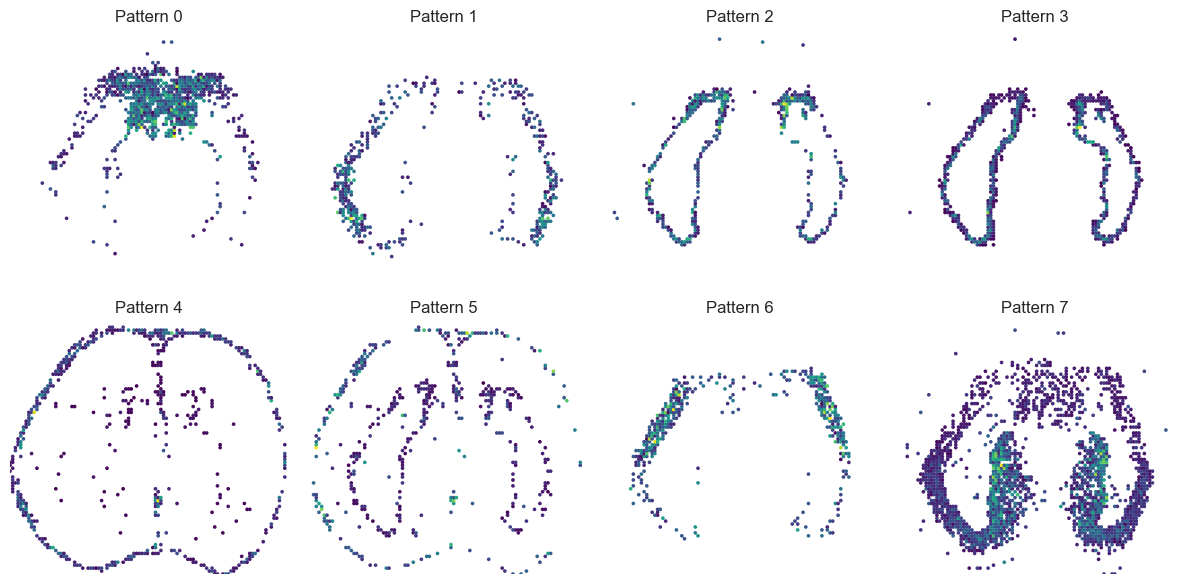

In [38]:
sp.plot.plot_pattern(vmax=99, vote_rate=0.25, heatmap=False, s=7,reverse_y=True)

In [1]:
sp.plot.plot_genes(label=3, vmax=99, plot_type='scatter',s=10)

NameError: name 'sp' is not defined

In [33]:
import pickle
with open('array.pkl', 'wb') as file:
    pickle.dump(sp.genes_distance_array, file)

In [64]:
gene_li = list(sp.genes_labels[sp.genes_labels['labels']==0]['gene_id'])

In [53]:
x_min = sp.adata.obsm['spatial'][:,1].min()
x_max = sp.adata.obsm['spatial'][:,1].max()
y_min = sp.adata.obsm['spatial'][:,0].min()
y_max = sp.adata.obsm['spatial'][:,0].max()
print(x_min, x_max, y_min,y_max)

0.0 4253.434806838026 0.0 5121.646928969367


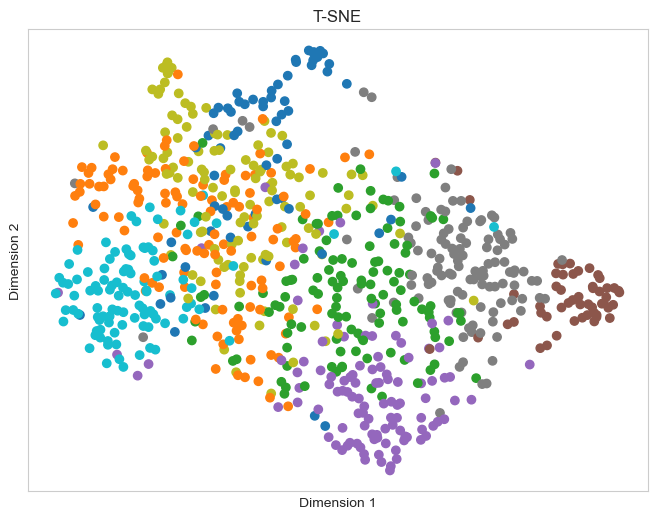

In [10]:
sp.plot.plot_tsne(method='umap')

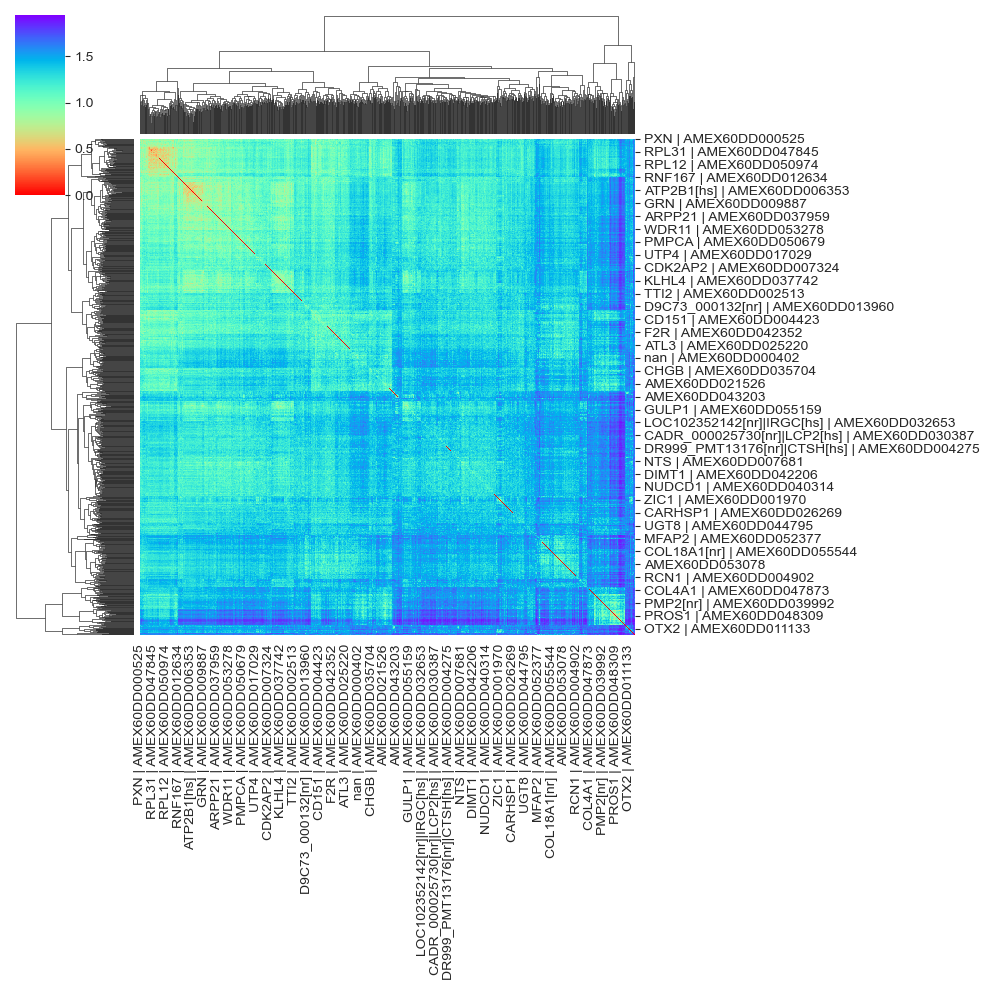

In [18]:
import seaborn as sns

sns.clustermap(sp.genes_distance_array,cmap='rainbow_r')

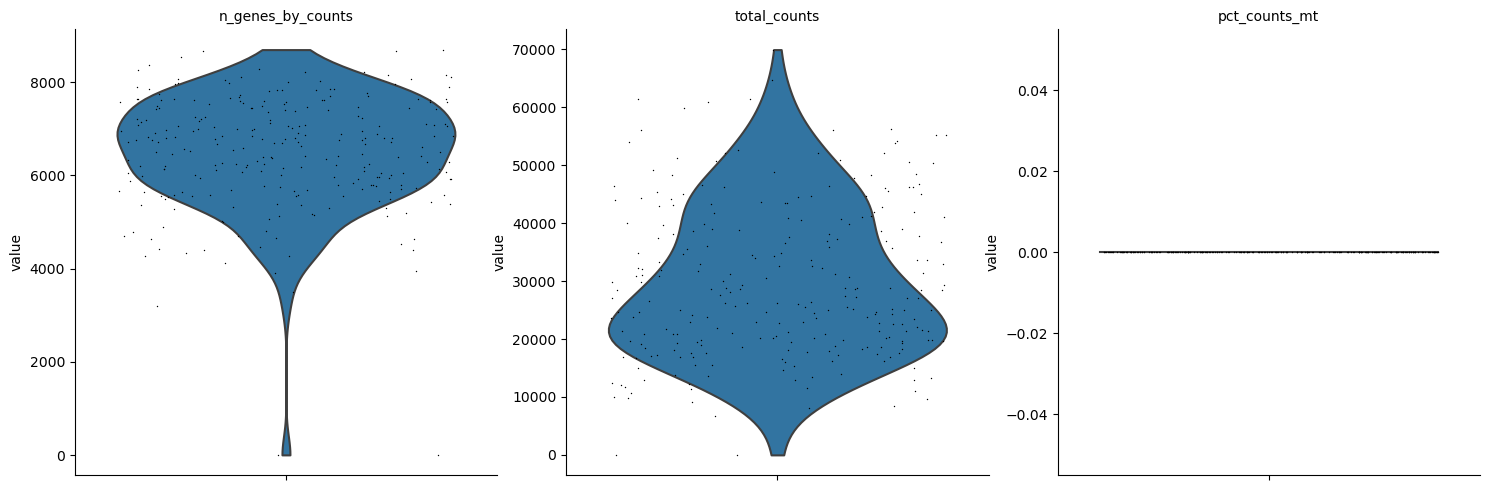

In [63]:

from Algorithm.distribution import *
from IO.read_10X import *
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = read_h5ad('F://Rep11_MOB_ST.h5ad', amplification=1000, bin_size=160)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
# sc.pp.filter_genes(adata, min_cells=50)


In [46]:
paper = ['Rab3b', 'Necab2', 'Tspan7', 'Cdr1', 'Slc17a7', '4933405L10Rik', 'Taf7l', 'Gna14', 'Olfr635', 'Pmepa1', 'Pcp4',
         'Apc', 'Rbfox3', 'Penk', 'Frzb', 'Fabp7', 'Slc6a11', 'Apod', 'S100a5', 'Arhgap33', 'Cplx1', 'Trnp1', 'Marcks',
         'Atp1b1', 'Vtn', 'Trak2', 'Igf1', 'Gabra1', 'Igfbp2', 'Lpar1', 'Omp', 'Kif5b', 'Sorbs1', 'Cck', 'Nr2f2',
         'Scd1', 'Cpe', 'Aqp4', 'Doc2g', 'Slc1a2', 'Nrgn', 'Cdhr1', 'Mcf2l', 'Kctd12', 'Unc13c', 'Foxd3', 'Prokr2',
         'Gng13', 'Kcnh3', 'Camk2b', 'Baiap2', 'Ccnd1', 'Gpsm1', 'Pbx1', 'Sepp1', 'Apoe', 'Tubb2b', 'Ncdn', 'Glul',
         'Sash1', 'Ptgds', 'Sparcl1', 'Mbp', 'Nrsn1', 'Igfbp5', 'Ptn', 'Sfrp5']
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)
# new_adata = adata[:,gene_list]
# result = convolve(get_3d_matrix(new_adata), method='gaussian', kernel_size=3)
# update_anndata(result, new_adata)

66